# Introduction

This study, conducted as part of my MSc research project, aimed to classify Autonomous System Numbers (ASNs) into tiers according to their peering behaviors and relationships. By employing sophisticated clustering techniques on an extensive dataset, the research aimed to unveil underlying patterns and hierarchies within network structures. The primary goal was to advance the comprehension of network topology, potentially contributing to network management, decision-making, and insights into the evolving landscape of internet infrastructure.

# Brief

This project uses data gotten from the ripe database, so only autnums registered in the ripe database are available in this project. 
Two dataset were retrieved from the ripe database, The autnum dataset and the AS-set dataset.

In [1]:
import pandas as pd
import re


In [2]:
cd /Users/macbook/Downloads/project_data


/Users/macbook/Downloads/Project_data


# The first step involved reading the AS-set dataset to retrieve the member count for each 
# as set name as this will be important for the analysis

In [3]:
FILENAME = 'ripe.db.as-set'
ASSET_NAME_PATTERN = re.compile("^as-set:\s+([^ ]+).*?$")
ASSET_MEMB_PATTERN = re.compile("^members:\s+([^ ]+).*?$")

asset_file = open(FILENAME, 'r', encoding='latin-1')

sets = {}
current_set = None
current_members = []
cont = True

while cont:
    line = asset_file.readline()

    if not line:
        if current_set not in sets:
            sets[current_set] = current_members

        cont = False

    else:
        match_name = ASSET_NAME_PATTERN.match(line)
        match_member = ASSET_MEMB_PATTERN.match(line)

        if match_name is not None:
            if current_set is not None:
                sets[current_set] = list(filter(lambda i: i.strip().upper() != "" , current_members))
            
            current_set = match_name.group(1).strip().upper()
            current_members = []
        
        elif match_member is not None and current_set is not None:
            members = match_member.group(1)
            if "," in members:
                members = [m.strip().upper() for m in members.split(",")]
                current_members += members
            else:
                current_members.append(match_member.group(1).strip().upper())

for key in sets:
    members = sets[key]
    new_members = []
    for item in members:
        if re.match("^AS\d+$", item):           
            new_members += [item]
        else:
            if item in sets:
                tmp = sets[item]
                if tmp is not None:
                    new_members += list(filter(lambda i: re.match("^AS\d+$", i), tmp))
                    others = list(filter(lambda i: not re.match("^AS\d+$", i), tmp))
                    while any(i in sets for i in new_members):
                        for i in others:
                            if i in sets:
                                new_members += sets[i]

                        others = others = list(filter(lambda i: not re.match("^AS\d+$", i), new_members))
                        
                    
    sets[key] = list(set(new_members))

setcounts = {k: 1 if len(v) == 0 else 999999 if "AS-ANY" in v or "AS-ALL" in v else len(v) for (k,v) in sets.items() }

sets = None
print(dict(list(setcounts.items())[:10]))


{'AS-RESTENA': 5, 'AS-TMPEBONECWIX': 3, 'AS-DFNFROMCOLOGNE': 2, 'AS-NETMATTERS': 2, 'AS-UDNGRAZ': 5, 'AS-DFNFROMESNET': 1, 'AS-GILINX': 1, 'AS-VERISAT': 1, 'AS-CASEMA': 1, 'AS-IAE': 1}


# Next is reading the second data that contains the autnum relationship. The text data was further engineered and many lines were removed for analysis.
# The data was engineered properly for my research, and line replacement was done.

In [4]:
import re

file_path = "ripe.db.aut-num"

def filter_lines(text):
    filtered_lines = []
    prev_line = ""

    for line in text:
        line = line.strip()  # Remove leading and trailing spaces
        
        if line.startswith(('mp-import','mp-export','import:', 'export:', 'aut-num:')):
            if line.startswith("aut-num:"):
                filtered_lines.append("\n" + line)
            else:
                filtered_lines.append(line)

    return '\n'.join(filtered_lines)

with open(file_path, 'r', encoding='latin-1') as file:
    content = file.readlines()

filtered_text = filter_lines(content[:-1])
datasets = filtered_text  # Use the entire filtered text

lines = datasets.strip().split('\n')

modified_lines = []
for line in lines:
    line = re.sub(r'\b(action|pref)\s*=\s*\S+\s*;', '', line).replace('action', '')
    modified_lines.append(line)

dataset = '\n'.join(modified_lines)
lines = dataset.strip().split('\n')

modified_lines = []
for line in lines:
    if 'accept' in line:
        words = line.split()
        if 'accept' not in words:
            modified_lines.append(line)
            continue
        index = words.index('accept')
        from_line = 'from: ' + words[index-1]
        accept_values = ' '.join(words[index+1:]).replace(';', '').split()
        accept_line = 'accept: ' + ', '.join(accept_values)
        modified_lines.append(from_line)
        modified_lines.append(accept_line)
    elif 'announce' in line:
        words = line.split()
        if 'announce' not in words:
            modified_lines.append(line)
            continue
        index = words.index('announce')
        to_line = 'To: ' + words[index-1]
        announce_values = ' '.join(words[index+1:]).replace(';', '').split()
        announce_line = 'announce: ' + ', '.join(announce_values)
        modified_lines.append(to_line)
        modified_lines.append(announce_line)
    else:
        modified_lines.append(line)

dataset = '\n'.join(modified_lines)

print(dataset[0:1000])


aut-num:        AS3255
To: AS3356
announce: AS-UARNET
from: AS3356
accept: ANY
To: AS174
announce: AS-UARNET
from: AS174
accept: ANY
To: AS174
announce: AS-UARNET
from: AS174
accept: ANY
To: AS8359
announce: AS-UARNET
from: AS8359
accept: ANY
To: AS3257
announce: AS-UARNET
from: AS3257
accept: ANY
To: AS3549
announce: AS-UARNET
from: AS3549
accept: ANY
To: AS9002
announce: AS-UARNET
from: AS9002
accept: ANY
To: AS9002
announce: AS-UARNET
from: AS9002
accept: ANY
To: AS31117
announce: AS-UARNET, AS-UAIX
from: AS31117
accept: AS-ENERGOTEL
To: AS8501
announce: AS-UARNET, AS-UAIX
from: AS8501
accept: AS-PLNET
To: AS35297
announce: AS-UARNET
from: AS35297
accept: AS-DL-WORLD
To: AS13188
announce: AS-UARNET
from: AS13188
accept: AS-BANKINFORM
To: AS12389
announce: AS-UARNET
from: AS12389
accept: AS-ROSTELECOM
To: AS50952
announce: AS-UARNET
from: AS50952
accept: AS-DATAIX
To: AS15645
announce: AS-UARNET, AS-PLNET, AS-ENERGOTEL
from: AS15645
accept: AS-UAIX
To: AS15645
announce: AS-UARNET
fro

# Further data processing was done to keep only the important lines for my analyis

In [5]:
modified_lines = []
lines = dataset.strip().split('\n')

for line in lines:
    if line.startswith(('from:', 'To:')):
        continue  # Skip lines starting with 'from:' or 'to:'

    line = line.replace('import:', 'accept:')
    line = line.replace('export:', 'announce:')
    line = line.replace('from', '')
    line = line.replace('to', '')

    modified_lines.append(line.strip())

modified_datasetss = '\n'.join(modified_lines)
print(modified_datasetss[0:1000])



aut-num:        AS3255
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET, AS-UAIX
accept: AS-ENERGOTEL
announce: AS-UARNET, AS-UAIX
accept: AS-PLNET
announce: AS-UARNET
accept: AS-DL-WORLD
announce: AS-UARNET
accept: AS-BANKINFORM
announce: AS-UARNET
accept: AS-ROSTELECOM
announce: AS-UARNET
accept: AS-DATAIX
announce: AS-UARNET, AS-PLNET, AS-ENERGOTEL
accept: AS-UAIX
announce: AS-UARNET
accept: AS-UAIX-v6
announce: AS-UARNET
accept: AS-DECIX
announce: AS-UARNET
accept: AS-DECIX-V6
announce: AS-UARNET
accept: AS-HURRICANE
announce: AS-UARNET
accept: AS-AKAMAI
announce: AS-UARNET
accept: AS-INIT7
announce: AS-UARNET
accept: AS-GTS-CE
announce: AS-UARNET
accept: AS-GLOBAL
announce: AS-UARNET
accept: AS-DIALTELECOM
announce: AS-UARNET
accept: AS-PCH
announce: AS-UARN

In [6]:
import re

autnum_lines = modified_datasetss.strip().split('\n\n')

restructured_data = []

for autnum_data in autnum_lines:
    lines = autnum_data.strip().split('\n')
    autnum = re.search(r'aut-num:\s*(\S+)', lines[0]).group(1)
    accept_lines = [line for line in lines if line.startswith('accept:')]
    announce_lines = [line for line in lines if line.startswith('announce:')]
    
    restructured_data.append(f"aut-num: {autnum}")
    restructured_data.extend([f"{accept}\n{announce}" for accept, announce in zip(accept_lines, announce_lines)])
    restructured_data.append('')

# Join the restructured data into a single string
output_ = '\n'.join(restructured_data)

# Print the output
print(output_[0:100000])



aut-num: AS3255
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: AS-ENERGOTEL
announce: AS-UARNET, AS-UAIX
accept: AS-PLNET
announce: AS-UARNET, AS-UAIX
accept: AS-DL-WORLD
announce: AS-UARNET
accept: AS-BANKINFORM
announce: AS-UARNET
accept: AS-ROSTELECOM
announce: AS-UARNET
accept: AS-DATAIX
announce: AS-UARNET
accept: AS-UAIX
announce: AS-UARNET, AS-PLNET, AS-ENERGOTEL
accept: AS-UAIX-v6
announce: AS-UARNET
accept: AS-DECIX
announce: AS-UARNET
accept: AS-DECIX-V6
announce: AS-UARNET
accept: AS-HURRICANE
announce: AS-UARNET
accept: AS-AKAMAI
announce: AS-UARNET
accept: AS-INIT7
announce: AS-UARNET
accept: AS-GTS-CE
announce: AS-UARNET
accept: AS-GLOBAL
announce: AS-UARNET
accept: AS-DIALTELECOM
announce: AS-UARNET
accept: AS-PCH
announce: AS-UARNET
accept: AS-PCH
announce:

# i did a count to see how many times each autnum accept and announce 'ANY'. The word
# 'ANY' in this case refers to a global reach. And it is important to find difference between a big isp and a smaller one. A small isp buying from 
# a bigger isp would accept any while the bigger isp would anounce Any.

# That means the isp that accepts Any is a downstream to the other Isp that announces Any if the Isp that accepts Any announces only itself.

In [7]:
autnums = output_.strip().split('\n\n')
results = []

for autnum_block in autnums:
    autnum_lines = autnum_block.strip().split('\n')
    if autnum_lines:
        autnum = autnum_lines[0]
        accept_lines = autnum_lines[1::2]
        announce_lines = autnum_lines[2::2]
        
        total_accept_any = len([line for line in accept_lines if line == 'accept: ANY'])
        total_announce_any = len([line for line in announce_lines if line == 'announce: ANY'])
        
        result = autnum + '\n'
        result += f'total_accept_any: {total_accept_any}\n'
        result += f'total_announce_any: {total_announce_any}\n'
        
        for accept, announce in zip(accept_lines, announce_lines):
            result += accept + '\n' + announce + '\n'
        
        results.append(result)

modified_output = '\n\n'.join(results)
print(modified_output[:1000])


aut-num: AS3255
total_accept_any: 11
total_announce_any: 415
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: AS-ENERGOTEL
announce: AS-UARNET, AS-UAIX
accept: AS-PLNET
announce: AS-UARNET, AS-UAIX
accept: AS-DL-WORLD
announce: AS-UARNET
accept: AS-BANKINFORM
announce: AS-UARNET
accept: AS-ROSTELECOM
announce: AS-UARNET
accept: AS-DATAIX
announce: AS-UARNET
accept: AS-UAIX
announce: AS-UARNET, AS-PLNET, AS-ENERGOTEL
accept: AS-UAIX-v6
announce: AS-UARNET
accept: AS-DECIX
announce: AS-UARNET
accept: AS-DECIX-V6
announce: AS-UARNET
accept: AS-HURRICANE
announce: AS-UARNET
accept: AS-AKAMAI
announce: AS-UARNET
accept: AS-INIT7
announce: AS-UARNET
accept: AS-GTS-CE
announce: AS-UARNET
accept: AS-GLOBAL
announce: AS-UARNET
accept: AS-DIALTELECOM
announce: AS-UARNET
accept: AS-PCH

# further claning was done to remove unwanted text from our data

In [8]:
lines = modified_output.strip().split('\n')
output_lines = []

for line in lines:
    if line.startswith('accept:') or line.startswith('announce:'):
        values = line.split(':', 1)[1].strip()
        if ' ' not in values:
            output_lines.append(line)
            continue
        
        values = values.split(', ')
        cleaned_values = [value.strip() for value in values if value.strip().startswith(('AS', ':AS', 'AS-', 'ANY'))]
        output_lines.append(f"{line.split(':')[0]}: {', '.join(cleaned_values)}")
    else:
        output_lines.append(line)

output = '\n'.join(output_lines)
print(output[:100000])


aut-num: AS3255
total_accept_any: 11
total_announce_any: 415
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: AS-ENERGOTEL
announce: AS-UARNET, AS-UAIX
accept: AS-PLNET
announce: AS-UARNET, AS-UAIX
accept: AS-DL-WORLD
announce: AS-UARNET
accept: AS-BANKINFORM
announce: AS-UARNET
accept: AS-ROSTELECOM
announce: AS-UARNET
accept: AS-DATAIX
announce: AS-UARNET
accept: AS-UAIX
announce: AS-UARNET, AS-PLNET, AS-ENERGOTEL
accept: AS-UAIX-v6
announce: AS-UARNET
accept: AS-DECIX
announce: AS-UARNET
accept: AS-DECIX-V6
announce: AS-UARNET
accept: AS-HURRICANE
announce: AS-UARNET
accept: AS-AKAMAI
announce: AS-UARNET
accept: AS-INIT7
announce: AS-UARNET
accept: AS-GTS-CE
announce: AS-UARNET
accept: AS-GLOBAL
announce: AS-UARNET
accept: AS-DIALTELECOM
announce: AS-UARNET
accept: AS-PCH

# i did a count to see how many members are accepted and announced for each autnum

In [9]:
search_strings = ['accept: ', 'announce: ']
replaced_data = ""
lines = output.strip().split('\n')

accept_counts = []
announce_counts = []

output_lines = []

for line in lines:
    replaced_line = line
    for search_string in search_strings:
        if search_string in line:
            set_names = line.split(':')[-1].strip().split(', ')
            modified_names = []
            for name in set_names:
                if name.startswith('AS-') and name[3:].isdigit():
                    modified_names.append('AS' + name[3:])
                else:
                    modified_names.append(name)
            replaced_line = line.replace(', '.join(set_names), ', '.join(modified_names))
            break
    replaced_data += replaced_line + '\n'

    if line.startswith('accept:'):
        accept_values = replaced_line.split(':')[1].strip().split(', ')
        accept_count = sum(1 for value in accept_values if value.strip().startswith('AS') and value.strip()[2:].isdigit())
        uncounted_members = [value.strip() for value in accept_values if not (value.strip().startswith('AS') and value.strip()[2:].isdigit())]
        if accept_count > 0:
            accept_counts.append(accept_count)
            if uncounted_members:
                output_lines.append('accept: ' + str(accept_count) + ', ' + ', '.join(uncounted_members))
            else:
                output_lines.append('accept: ' + str(accept_count))
        else:
            output_lines.append('accept: ' + ', '.join(uncounted_members))
    elif line.startswith('announce:'):
        announce_values = replaced_line.split(':')[1].strip().split(', ')
        announce_count = sum(1 for value in announce_values if value.strip().startswith('AS') and value.strip()[2:].isdigit())
        uncounted_members = [value.strip() for value in announce_values if not (value.strip().startswith('AS') and value.strip()[2:].isdigit())]
        if announce_count > 0:
            announce_counts.append(announce_count)
            if uncounted_members:
                output_lines.append('announce: ' + str(announce_count) + ', ' + ', '.join(uncounted_members))
            else:
                output_lines.append('announce: ' + str(announce_count))
        else:
            output_lines.append('announce: ' + ', '.join(uncounted_members))
    else:
        output_lines.append(replaced_line)

output = '\n'.join(output_lines)
resultsss = "Replaced output:\n" + output + "\naccept_counts: " + str(accept_counts) + "\nannounce_counts: " + str(announce_counts)
print(resultsss[0:1000])


Replaced output:
aut-num: AS3255
total_accept_any: 11
total_announce_any: 415
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: ANY
announce: AS-UARNET
accept: AS-ENERGOTEL
announce: AS-UARNET, AS-UAIX
accept: AS-PLNET
announce: AS-UARNET, AS-UAIX
accept: AS-DL-WORLD
announce: AS-UARNET
accept: AS-BANKINFORM
announce: AS-UARNET
accept: AS-ROSTELECOM
announce: AS-UARNET
accept: AS-DATAIX
announce: AS-UARNET
accept: AS-UAIX
announce: AS-UARNET, AS-PLNET, AS-ENERGOTEL
accept: AS-UAIX-v6
announce: AS-UARNET
accept: AS-DECIX
announce: AS-UARNET
accept: AS-DECIX-V6
announce: AS-UARNET
accept: AS-HURRICANE
announce: AS-UARNET
accept: AS-AKAMAI
announce: AS-UARNET
accept: AS-INIT7
announce: AS-UARNET
accept: AS-GTS-CE
announce: AS-UARNET
accept: AS-GLOBAL
announce: AS-UARNET
accept: AS-DIALTELECOM
announce: AS-UARN

# i replaced the as-set name with their member count

In [10]:
lines = resultsss.strip().split('\n')
output_lines = []
for line in lines:
    if line.startswith('accept:') or line.startswith('announce:'):
        set_names = line.split(':')[1].strip().split(', ')
        line_sum = sum(int(setcounts.get(name, '1')) for name in set_names if name.strip().lower() not in {'any', 'any,'})
        if any(name.strip().lower() in {'any', 'any,'} for name in set_names):
            output_lines.append(line.split(':')[0] + ': any')
        else:
            output_lines.append(line.split(':')[0] + ': ' + str(line_sum))
    else:
        output_lines.append(line)

new_output = '\n'.join(output_lines)
print(new_output[0:1000])



Replaced output:
aut-num: AS3255
total_accept_any: 11
total_announce_any: 415
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: 45
announce: 4102
accept: 39
announce: 4102
accept: 1002
announce: 1153
accept: 30
announce: 1153
accept: 10609
announce: 1153
accept: 16883
announce: 1153
accept: 2949
announce: 1237
accept: 1
announce: 1153
accept: 21930
announce: 1153
accept: 32507
announce: 1153
accept: 1
announce: 1153
accept: 33
announce: 1153
accept: 1
announce: 1153
accept: 1609
announce: 1153
accept: 226
announce: 1153
accept: 164
announce: 1153
accept: 1
announce: 1153
accept: 1
announce: 1153
accept: 1
announce: 1153
accept: 6
announce: 1153
accept: 88
announce: 1153
accept: 29
announce: 1153
accept: 35
announce: 1153
accept: 1
announce: 1153
accept: 1
announce: 1153
accept: 1
announce: 1153
accept: 10890
announ

# i checked for the upstream, peering and downstream count for each autnum. 
# two different peering was observed. the big peering is usually between two tier 1, ANY to ANY
# while the small peering is observed by smaller isps, 1 to 1

In [11]:
output_lines = []
autnum_count = 0
upstream_count = 0
downstream_count = 0
big_peering_count = 0
small_peering_count = 0
total_accept = 0  # Initialize total_accept variable

for line in new_output.strip().split('\n'):
    if line.startswith('aut-num:'):
        autnum_count += 1
        if autnum_count > 1:
            # Append the counts and total_accept for the previous aut-num entry with an extra line space
            output_lines.append('Upstream Count: ' + str(upstream_count))
            output_lines.append('Downstream Count: ' + str(downstream_count))
            output_lines.append('Big Peering Count: ' + str(big_peering_count))
            output_lines.append('Small Peering Count: ' + str(small_peering_count))
            output_lines.append('Total Accept: ' + str(total_accept))
            output_lines.append('')

            # Reset the counts and total_accept for the next aut-num entry
            upstream_count = 0
            downstream_count = 0
            big_peering_count = 0
            small_peering_count = 0
            total_accept = 0

    elif line.startswith('accept:'):
        accept_value = line.split(': ')[1].strip()
        if accept_value == 'any':
            accept_value = float('inf')
        else:
            accept_value = int(accept_value)
        if accept_value != float('inf'):  # Skip 'any' values in the total_accept calculation
            total_accept += accept_value
    
    elif line.startswith('announce:'):
        announce_value = line.split(': ')[1].strip()
        if announce_value == 'any':
            announce_value = float('inf')
        else:
            announce_value = int(announce_value)

        if accept_value is not None and announce_value is not None:
            if accept_value == float('inf') and announce_value == float('inf'):
                big_peering_count += 1
            elif (accept_value == 1 and announce_value == 1) or \
                    (accept_value != float('inf') and announce_value != float('inf') and
                     accept_value > 0 and announce_value > 0 and abs(accept_value - announce_value) < 1000):
                small_peering_count += 1
            elif accept_value == float('inf') or (accept_value > announce_value +10):
                upstream_count += 1
            elif accept_value < announce_value - 1000 or announce_value == float('inf'):
                downstream_count += 1
        
        accept_value = None
        announce_value = None
    
    # Append the line to the output_lines without an extra line space
    output_lines.append(line)

# Append the counts and total_accept for the last aut-num without an extra line space
output_lines.append('Upstream Count: ' + str(upstream_count))
output_lines.append('Downstream Count: ' + str(downstream_count))
output_lines.append('Big Peering Count: ' + str(big_peering_count))
output_lines.append('Small Peering Count: ' + str(small_peering_count))
output_lines.append('Total Accept: ' + str(total_accept))

output1 = '\n'.join(output_lines)
print(output1[:1000])


Replaced output:
aut-num: AS3255
total_accept_any: 11
total_announce_any: 415
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: any
announce: 1153
accept: 45
announce: 4102
accept: 39
announce: 4102
accept: 1002
announce: 1153
accept: 30
announce: 1153
accept: 10609
announce: 1153
accept: 16883
announce: 1153
accept: 2949
announce: 1237
accept: 1
announce: 1153
accept: 21930
announce: 1153
accept: 32507
announce: 1153
accept: 1
announce: 1153
accept: 33
announce: 1153
accept: 1
announce: 1153
accept: 1609
announce: 1153
accept: 226
announce: 1153
accept: 164
announce: 1153
accept: 1
announce: 1153
accept: 1
announce: 1153
accept: 1
announce: 1153
accept: 6
announce: 1153
accept: 88
announce: 1153
accept: 29
announce: 1153
accept: 35
announce: 1153
accept: 1
announce: 1153
accept: 1
announce: 1153
accept: 1
announce: 1153
accept: 10890
announ

# Data transformation: Converting data to dataframe for futher analysis


In [12]:
import pandas as pd


lines = output1.strip().split('\n')  # Split the output by newlines
data = []  # List to store dictionaries representing each aut-num entry
entry = {}  # Dictionary to store counts for an aut-num entry

for line in lines:
    if ':' not in line:  # Check if the line has the expected format (key: value)
        continue
    key, value = line.split(':', 1)  # Split each line into key-value pairs
    entry[key.strip()] = value.strip()

    if key.startswith('Total Accept'):  # Check if the last line of the current entry is reached
        data.append(entry)  # Add the entry to the list of data
        entry = {}  # Reset the entry for the next aut-num

# Convert to DataFrame
df = pd.DataFrame(data)[['aut-num', 'Upstream Count', 'Downstream Count', 'Big Peering Count', 'Small Peering Count', 'Total Accept']]
df = df.fillna('')  # Fill missing values with empty strings

print(df)


        aut-num Upstream Count Downstream Count Big Peering Count  \
0        AS3255             18              436                 0   
1        AS6837              1                1                 0   
2       AS15756             13               25                 0   
3       AS16054              1               17                 0   
4        AS9205              3                1                 0   
...         ...            ...              ...               ...   
38592  AS198080              3                0                 0   
38593  AS198079              2                0                 0   
38594  AS198078              2                0                 0   
38595  AS198077              0                0                 0   
38596  AS198075              2                0                 0   

      Small Peering Count Total Accept  
0                       4       121871  
1                       0            1  
2                      44        55204  
3      

In [13]:
df

,aut-num,Upstream Count,Downstream Count,Big Peering Count,Small Peering Count,Total Accept
0,AS3255,18,436,0,4,121871
1,AS6837,1,1,0,0,1
2,AS15756,13,25,0,44,55204
3,AS16054,1,17,0,8,77
4,AS9205,3,1,0,0,1
...,...,...,...,...,...,...
38592,AS198080,3,0,0,0,0
38593,AS198079,2,0,0,0,0
38594,AS198078,2,0,0,0,0
38595,AS198077,0,0,0,0,0


# Data Engineering: Creating features from exissting features
# to find possible stretch on the data

In [14]:
import pandas as pd

lines = output1.strip().split('\n')  # Split the output by newlines
data = []  # List to store dictionaries representing each aut-num entry
entry = {}  # Dictionary to store counts for an aut-num entry

for line in lines:
    if ':' not in line:  # Check if the line has the expected format (key: value)
        continue
    key, value = line.split(':', 1)  # Split each line into key-value pairs
    entry[key.strip()] = value.strip()

    if key.startswith('Total Accept'):  # Check if the last line of the current entry is reached
        # Calculate the new columns 'd_s', 'd_m', and 'd_L' based on 'Downstream Count'
        downstream_count = int(entry.get('Downstream Count', 0))
        entry['d_s'] = 1 if downstream_count == 1 else 0
        entry['d_m'] = 1 if 1 < downstream_count <= 1000 else 0
        entry['d_L'] = 1 if downstream_count > 1000 else 0
        
        Total_count = int(entry.get('Total Accept', 0))
        entry['T_s'] = 1 if Total_count == 1 else 0
        entry['T_m'] = 1 if 1 < Total_count <= 10000 else 0
        entry['T_L'] = 1 if Total_count > 10000 else 0

        data.append(entry)  # Add the entry to the list of data
        entry = {}  # Reset the entry for the next aut-num

# Convert to DataFrame
df = pd.DataFrame(data)[['aut-num', 'Upstream Count', 'Downstream Count', 'Big Peering Count', 'Small Peering Count', 'd_s', 'd_m', 'd_L','T_s', 'T_m', 'T_L',]]
df = df.fillna('')  # Fill missing values with empty strings

print(df)


        aut-num Upstream Count Downstream Count Big Peering Count  \
0        AS3255             18              436                 0   
1        AS6837              1                1                 0   
2       AS15756             13               25                 0   
3       AS16054              1               17                 0   
4        AS9205              3                1                 0   
...         ...            ...              ...               ...   
38592  AS198080              3                0                 0   
38593  AS198079              2                0                 0   
38594  AS198078              2                0                 0   
38595  AS198077              0                0                 0   
38596  AS198075              2                0                 0   

      Small Peering Count  d_s  d_m  d_L  T_s  T_m  T_L  
0                       4    0    1    0    0    0    1  
1                       0    1    0    0    1    0    0

# data transformation: converting data to binary data to find patterns in my data

In [15]:
import pandas as pd

df_without_autnum = df.iloc[:, 1:]

# Convert numeric values greater than or equal to 1 to 1 and the rest to 0
df_without_autnum = df_without_autnum.applymap(lambda x: 1 if pd.to_numeric(x, errors='coerce') >= 1 else 0)

# Concatenate 'aut-num' column with the updated DataFrame
df_updated = pd.concat([df['aut-num'], df_without_autnum], axis=1)

print(df_updated)


        aut-num  Upstream Count  Downstream Count  Big Peering Count  \
0        AS3255               1                 1                  0   
1        AS6837               1                 1                  0   
2       AS15756               1                 1                  0   
3       AS16054               1                 1                  0   
4        AS9205               1                 1                  0   
...         ...             ...               ...                ...   
38592  AS198080               1                 0                  0   
38593  AS198079               1                 0                  0   
38594  AS198078               1                 0                  0   
38595  AS198077               0                 0                  0   
38596  AS198075               1                 0                  0   

       Small Peering Count  d_s  d_m  d_L  T_s  T_m  T_L  
0                        1    0    1    0    0    0    1  
1                

# Removing autnum with no data values for a better analysis

In [16]:
# Assuming your DataFrame is named 'df' and 'autnum' is the column containing the ASN numbers


df1 = df_updated[~(df_updated[['Upstream Count', 'Downstream Count', 'Big Peering Count','Small Peering Count']] == 0).all(axis=1)]
df1 = df1.reset_index(drop=True)

# using dendogram to visualise the number of clusters suitable for the analysis

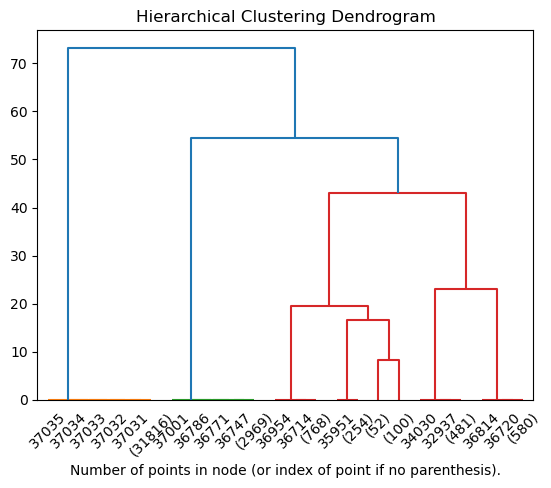

In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

subset_data = df1.iloc[:37036 , 1:4].copy()  # Exclude the 'Aut-num' column

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = subset_data.values.astype(float)  # Convert the data to a numeric array

# Set distance_threshold=None to compute the full tree
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
labels=model.labels_
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


In [18]:

clustering = AgglomerativeClustering(n_clusters=6,linkage="complete")

clustering= clustering.fit(subset_data)
labelss=clustering.labels_
print(labelss)

[4 4 4 ... 2 2 2]


# Clustering results

Six clusters were uncovered from the analysis.

* Cluster 5 can be considered to be the backbone network, these group are categorisedwith having no upstreams at all.

* cluster 1 and 4 can be considered to be tier 2 networks. The difference is, cluster 4 have mixed peering,  that means, they show peering relationship like tier 1 networks

* cluster 2 can be considered to be tier 3 networks. They have no customers.

* Cluster 0 engage with Big peerings only while cluster 3 engage in small peerings only

In [33]:
subset_size = 30000
labels_0 = df1[:subset_size].loc[labelss[:subset_size] == 0, 'aut-num'].tolist()
labels_1 = df1[:subset_size].loc[labelss[:subset_size] == 5, 'aut-num'].tolist()
labels_2 = df1[:subset_size].loc[labelss[:subset_size] == 3, 'aut-num'].tolist()

print("AS numbers with label 0:", labels_1)

AS numbers with label 0: ['AS6817', 'AS6816', 'AS8338', 'AS1304', 'AS1121', 'AS8486', 'AS12582', 'AS719', 'AS15424', 'AS8459', 'AS16168', 'AS6785', 'AS20530', 'AS9153', 'AS1887', 'AS13124', 'AS20483', 'AS3301', 'AS3257', 'AS8210', 'AS6830', 'AS20694', 'AS8501', 'AS8333', 'AS20640', 'AS3343', 'AS1901', 'AS1836', 'AS1299', 'AS13121', 'AS12322', 'AS16374', 'AS24607', 'AS8545', 'AS25441', 'AS25530', 'AS29075', 'AS29131', 'AS30778', 'AS30865', 'AS31044', 'AS31210', 'AS34396', 'AS35302', 'as39003', 'AS39461', 'AS39561', 'AS43252', 'AS43559', 'AS44412', 'AS44530', 'AS47200', 'AS47228', 'AS47506', 'AS44208', 'AS48625', 'AS196624', 'AS49229', 'AS49485', 'AS50125', 'AS50187', 'AS50278', 'AS50607', 'AS51357', 'AS51759', 'AS51794', 'AS2027', 'AS20641', 'AS20821', 'AS56890', 'AS57859', 'AS58095', 'AS59542', 'AS198091', 'AS59712', 'AS61374', 'AS60832', 'AS60763', 'AS60500', 'AS60493', 'AS60430', 'AS60429', 'AS199798', 'AS201227', 'AS25083', 'AS20717', 'AS20715', 'AS203921', 'AS203573', 'AS203288', '

In [20]:
import pandas as pd

# Assuming 'df1' is your original DataFrame containing the data
# Filter the DataFrame for 'AS5511'
as5511_df = df[df['aut-num'] == 'AS6774']

# Display the filtered DataFrame
print(as5511_df)

     aut-num Upstream Count Downstream Count Big Peering Count  \
2427  AS6774              1                1                 0   

     Small Peering Count  d_s  d_m  d_L  T_s  T_m  T_L  
2427                   3    1    0    0    0    1    0  


# visualising the distribution of autnum across all clusters

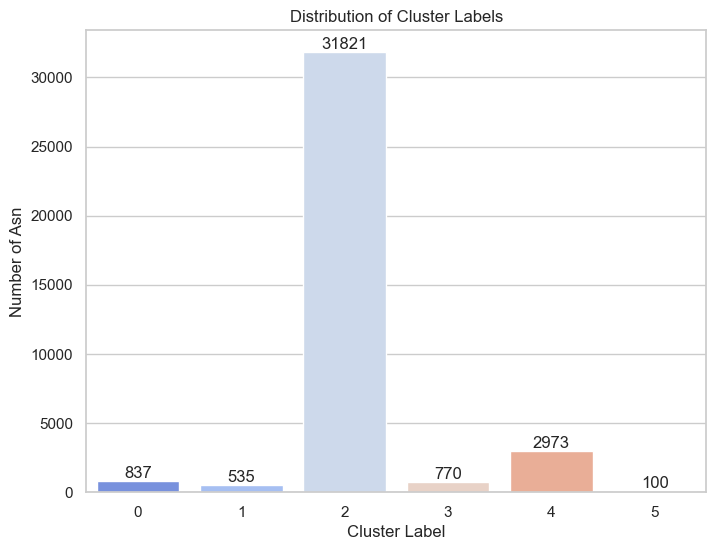

In [21]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
cluster_counts = pd.Series(labelss).value_counts().sort_index()

# Create a bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='coolwarm')
plt.title('Distribution of Cluster Labels')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Asn')

# Annotate each bar with the count
for i, count in enumerate(cluster_counts.values):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()


In [22]:
import numpy as np


index = np.where(df1['aut-num'] == 'AS1942')[0]

if len(index) > 0:
    label = labelss[index[0]]
    print("Label of AS3320:", label)
else:
    print("AS3320 not found in the DataFrame")

Label of AS3320: 2


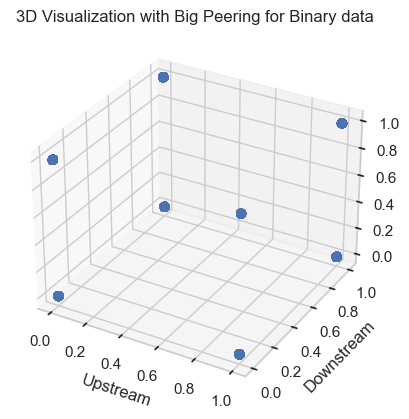

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming df is your DataFrame
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(df1['Downstream Count'],df1['Upstream Count'], df1['Big Peering Count'], s=40)

# Set axis labels
ax.set_xlabel('Upstream')
ax.set_ylabel('Downstream')
ax.set_zlabel('Z Label', labelpad=15)

# Set title
ax.set_title('3D Visualization with Big Peering for Binary data')


plt.show()


# Checking accuracy of my results 
# by comparing the seven asn listed as tier1 by caida's ASranking 
# with my analysis

In [24]:
import numpy as np

asn_list = ['AS1299', 'AS6762', 'AS3257', 'AS5511', 'AS3320', 'as12956', 'AS6830']

for asn in asn_list:
    index = np.where(df1['aut-num'] == asn)[0]
    
    if len(index) > 0:
        label = labelss[index[0]]
        print(f"Label of {asn}: {label}")
    else:
        print(f"{asn} not found in the DataFrame")


Label of AS1299: 5
Label of AS6762: 1
Label of AS3257: 5
Label of AS5511: 1
Label of AS3320: 0
Label of as12956: 4
Label of AS6830: 5


3 out of 7 were in same cluster aligning with caida's analysis. But it is important to note that caida only uses ipv4 data
as oppose to this analysis that uses both ipv6 and ipv4. When compared to radar.qrator.net, 5/7 were correct.

# Checking accuracy of my results for tier2 networks
# by comparing it with caida's ASranking

In [25]:
import re

asn_data = """
Page 5
31027 ( Denmark)
13237 (Germany)
6774 (Belgium)
29535 (Poland)
12302(Romania)
5400(Uk) 
29119(Spain)
199231(Finland)
8641(Russia)
2603(Denmark)

Page 6
60299(Russia)
50263(Ukraine)
1257(Sweden)
3215 (France)
8732 (Russia)
24724(Poland)
12874(Italy)
9050(Romania)
212508(Italy)
29226(Russia)
15924(Turkey)
13030(Switzerland )
8455(Holland)
30781(France)
8881(Germany)
8717(Bulgaria)
3269(Italy)

Page 7
3209( Germany)
39533(Hungary)
2119(Norway)
25478(Ukraine)
50581(Ukraine)
34549(Germany)
29075(France)
2956(United kingdom)
5603(Slovenia)
35168(Kazakhstan )
57344(Bulgaria)
50673(Holland)
41327(Italy)
48858(Russia)
16019(Czech)
8400(Serbia )
13249(Ukraine)
44901(Bulgaria)
Page 8
12579( Latvia)
3292(Denmark)
8866(Bulgaria)
199995(Ukraine)
13194(Lithuania)
59900(Bulgaria)
6730(Switzerland)
12883( Ukraine)

Page 9
3267( Russia)
59613(Ukraine 
28716(Italy)
50629(Germany)
44530(France )
5606(Romania)
2854(Russia)
201706(Russia)
12479(Spain)
34224(Bulgaria)
5391(Croatia)
12430(Spain)
198949(Israel)
34309(Germany
24748(Poland)
"""

pattern = r'(\d+)\s*\('
asns = re.findall(pattern, asn_data)
asns_with_prefix = ['AS' + asn for asn in asns]

# Additional ASNs for page 10
additional_asns = [
    'AS12389', 'AS15412', 'AS12552', 'AS4455', 'AS2856', 'AS31133', 'AS20485', 'AS9002', 'AS4455', 'AS8359', 
    'AS35598', 'AS31500', 'AS16265', 'AS50509', 'AS9049', 'AS3303', 'AS6663', 'AS20965', 'AS29076', 'AS20562', 
    'AS3326', 'AS35297', 'AS24785', 'AS15830', 'AS9121', 'AS50607', 'AS25291', 'AS35320', 'AS201054', 'AS3255', 
    'AS57724', 'AS1764', 'AS21320', 'AS30844', 'AS29049', 'AS35280', 'AS31042', 'AS34984', 'AS5617', 'AS20495', 
    'AS8218', 'AS8447', 'AS31027', 'AS13237', 'AS6774', 'AS12302', 'AS5400', 'AS29119', 'AS199231', 'AS8641','AS6667', 'AS12695', 'AS47605', 'AS29208', 'AS57866', 'AS3352', 'AS12713', 'AS31287', 'AS3301', 'AS6768', 
    'AS8657', 'AS24961', 'AS50606', 'AS12963', 'AS6855', 'AS49063', 'AS39737', 'AS15557', 'AS2116', 'AS8764', 
    'AS15576', 'AS12357',    'AS31242', 'AS1267', 'AS9198', 'AS60280', 'AS34779', 'AS5089', 'AS12310', 'AS1853', 
    'AS15576', 'AS15895', 'AS5483', 'AS41494', 'AS59796', 'AS8412', 'AS8767', 'AS202766', 
    'AS34927', 'AS6849', 'AS8501', 'AS12779', 'AS9119', 'AS24940', 'AS6696', 'AS8926', 
    'AS21385', 'AS58115', 'AS25180', 'AS31025', 'AS8932', 'AS8437', 'AS5518', 'AS47232', 
    'AS15836', 'AS44735', 'AS62240', 'AS559', 'AS3300', 'AS8422', 'AS25394', 'AS49600', 
    'AS1836', 'AS30950', 'AS15958', 'AS29518', 'AS5398', 'AS48648', 'AS15570', 'AS6846', 
    'AS12337', 'AS16302', 'AS41998', 'AS48024', 'AS44684', 'AS50304', 'AS8637', 'AS6677',    'AS9063', 'AS48422', 'AS43139', 'AS12687', 'AS15600', 'AS12703', 'AS25577', 'AS24637', 
    'AS60159', 'AS8751', 'AS31313', 'AS553', 'AS6848', 'AS42831', 'AS39351', 'AS13287', 
    'AS50309', 'AS12593', 'AS212815', 'AS766', 'AS12306', 'AS8468', 'AS12969', 'AS15695', 
    'AS1103', 'AS50266', 'AS44339', 'AS48918', 'AS51048', 'AS199610', 'AS12541', 'AS8903', 
    'AS49697', 'AS196610', 'AS5410', 'AS6739', 'AS5413', 'AS56910', 'AS6908', 'AS60169', 
    'AS16347', 'AS8368', 'AS21473', 'AS29691', 'AS34867', 'AS29491', 'AS3308', 'AS12844', 
    'AS8647', 'AS56595', 'AS3342', 'AS34056', 'AS15497', 'AS198477', 'AS41820', 'AS13285', 
    'AS12338', 'AS39608', 'AS49685',    'AS2486', 'AS2541', 'AS4589', 'AS8346', 'AS2027', 'AS20940', 'AS8323', 'AS12859', 
    'AS58321', 'AS20811', 'AS24971', 'AS43833', 'AS199803', 'AS34977', 'AS29414', 'AS9136', 
    'AS2072', 'AS2108', 'AS2110', 'AS2116', 'AS2118', 'AS2119', 'AS2134', 'AS2200', 'AS9902', 
    'AS2470', 'AS34304', 'AS31034', 'AS12637', 'AS48173', 'AS39120', 'AS44592', 'AS12773', 
    'AS49895', 'AS57717', 'AS48161', 'AS47869', 'AS5539', 'AS15954', 'AS35369', 'AS60695', 
    'AS210104', 'AS24723','AS16342', 'AS205185', 'AS49127', 'AS30851', 'AS43366', 'AS8339', 'AS31477', 'AS25540'
]

# Combine the lists
all_asns = asns_with_prefix + additional_asns

print(all_asns)


['AS31027', 'AS13237', 'AS6774', 'AS29535', 'AS12302', 'AS5400', 'AS29119', 'AS199231', 'AS8641', 'AS2603', 'AS60299', 'AS50263', 'AS1257', 'AS3215', 'AS8732', 'AS24724', 'AS12874', 'AS9050', 'AS212508', 'AS29226', 'AS15924', 'AS13030', 'AS8455', 'AS30781', 'AS8881', 'AS8717', 'AS3269', 'AS3209', 'AS39533', 'AS2119', 'AS25478', 'AS50581', 'AS34549', 'AS29075', 'AS2956', 'AS5603', 'AS35168', 'AS57344', 'AS50673', 'AS41327', 'AS48858', 'AS16019', 'AS8400', 'AS13249', 'AS44901', 'AS12579', 'AS3292', 'AS8866', 'AS199995', 'AS13194', 'AS59900', 'AS6730', 'AS12883', 'AS3267', 'AS59613', 'AS28716', 'AS50629', 'AS44530', 'AS5606', 'AS2854', 'AS201706', 'AS12479', 'AS34224', 'AS5391', 'AS12430', 'AS198949', 'AS34309', 'AS24748', 'AS12389', 'AS15412', 'AS12552', 'AS4455', 'AS2856', 'AS31133', 'AS20485', 'AS9002', 'AS4455', 'AS8359', 'AS35598', 'AS31500', 'AS16265', 'AS50509', 'AS9049', 'AS3303', 'AS6663', 'AS20965', 'AS29076', 'AS20562', 'AS3326', 'AS35297', 'AS24785', 'AS15830', 'AS9121', 'AS50

In [26]:
count = len(all_asns)
print("Total number of ASNs:", count)

Total number of ASNs: 306


In [27]:
filtered_asns = [asn for asn in all_asns if asn in df1['aut-num'].values]
print("Total number of ASNs in DataFrame:", len(filtered_asns))


Total number of ASNs in DataFrame: 295


In [28]:
unique_asns = set(filtered_asns)

if len(unique_asns) == len(filtered_asns):
    print("All ASNs in the list are unique.")
else:
    print("There are duplicate ASNs in the list.")


There are duplicate ASNs in the list.


In [29]:
len(unique_asns)

283

In [30]:
import random

sample_size = 25
num_samples = 10

random_samples = []

for _ in range(num_samples):
    if len(unique_asns) >= sample_size:
        sample = random.sample(filtered_asns, sample_size)
        random_samples.append(sample)
        filtered_asns = [asn for asn in filtered_asns if asn not in sample]
    else:
        break

for idx, sample in enumerate(random_samples, start=1):
    print(f"Sample {idx}: {sample}")


Sample 1: ['AS8412', 'AS48918', 'AS5483', 'AS6855', 'AS3301', 'AS13249', 'AS6677', 'AS24940', 'AS60695', 'AS43833', 'AS34304', 'AS12637', 'AS199995', 'AS8647', 'AS205185', 'AS29119', 'AS8717', 'AS8359', 'AS59900', 'AS5089', 'AS199231', 'AS16265', 'AS12541', 'AS60169', 'AS29049']
Sample 2: ['AS34927', 'AS1267', 'AS1764', 'AS31133', 'AS24724', 'AS15895', 'AS50263', 'AS20965', 'AS3342', 'AS44592', 'AS9063', 'AS57724', 'AS35280', 'AS44901', 'AS31477', 'AS12703', 'AS57344', 'AS13285', 'AS2134', 'AS8437', 'AS6774', 'AS41327', 'AS15557', 'AS35598', 'AS6696']
Sample 3: ['AS553', 'AS199803', 'AS29414', 'AS8657', 'AS5400', 'AS16347', 'AS2108', 'AS6768', 'AS48161', 'AS8400', 'AS20811', 'AS6848', 'AS49600', 'AS13287', 'AS202766', 'AS59796', 'AS25394', 'AS43139', 'AS6663', 'AS2116', 'AS12306', 'AS25291', 'AS3255', 'AS24785', 'AS29491']
Sample 4: ['AS6739', 'AS35168', 'AS3303', 'AS1836', 'AS12337', 'AS49127', 'AS56910', 'AS24971', 'AS8455', 'AS6667', 'AS48024', 'AS8866', 'AS12773', 'AS2200', 'AS5398

In [31]:
import numpy as np

true_labels = [4, 1]
correct_predictions = 0
total_asns = len(unique_asns)
label_count_dict = {}

for asn in unique_asns:
    index = np.where(df1['aut-num'] == asn)[0]
    
    if len(index) > 0:
        label = labelss[index[0]]
        if label in label_count_dict:
            label_count_dict[label] += 1
        else:
            label_count_dict[label] = 1
        
        # Predict the label based on true_labels
        if label in true_labels:
            correct_predictions += 1
    else:
        print(f"{asn} not found in the DataFrame")

# Print the label count
for label, count in label_count_dict.items():
    print(f"Label {label}: Count = {count}")

accuracy = (correct_predictions / total_asns) * 100
print(f"Accuracy: {accuracy:.2f}%")


Label 2: Count = 69
Label 4: Count = 155
Label 5: Count = 8
Label 1: Count = 41
Label 3: Count = 3
Label 0: Count = 7
Accuracy: 69.26%


In [32]:
import numpy as np

true_labels = [4, 1]
total_samples = 10
label_count_dict_list = []
accuracy_list = []

for sample in random_samples:
    correct_predictions = 0
    label_count_dict = {}
    
    for asn in sample:
        index = np.where(df1['aut-num'] == asn)[0]
        
        if len(index) > 0:
            label = labelss[index[0]]
            if label in label_count_dict:
                label_count_dict[label] += 1
            else:
                label_count_dict[label] = 1
        
        if label in true_labels:
            correct_predictions += 1
    
    label_count_dict_list.append(label_count_dict)
    accuracy = (correct_predictions / len(sample)) * 100
    accuracy_list.append(accuracy)

# Print label counts and accuracy for each sample
for i, (label_count_dict, accuracy) in enumerate(zip(label_count_dict_list, accuracy_list), start=1):
    print(f"Sample {i}:")
    for label, count in label_count_dict.items():
        print(f"Label {label}: Count = {count}")
    print(f"Accuracy: {accuracy:.2f}%")
    print()

# Calculate and print the average accuracy
average_accuracy = sum(accuracy_list) / total_samples
print(f"Average Accuracy: {average_accuracy:.2f}%")


Sample 1:
Label 4: Count = 14
Label 2: Count = 7
Label 5: Count = 1
Label 1: Count = 3
Accuracy: 68.00%

Sample 2:
Label 4: Count = 15
Label 1: Count = 3
Label 5: Count = 1
Label 3: Count = 2
Label 2: Count = 3
Label 0: Count = 1
Accuracy: 72.00%

Sample 3:
Label 4: Count = 14
Label 2: Count = 8
Label 1: Count = 2
Label 0: Count = 1
Accuracy: 64.00%

Sample 4:
Label 1: Count = 4
Label 5: Count = 1
Label 4: Count = 12
Label 2: Count = 5
Label 0: Count = 3
Accuracy: 64.00%

Sample 5:
Label 2: Count = 7
Label 4: Count = 13
Label 1: Count = 4
Label 5: Count = 1
Accuracy: 68.00%

Sample 6:
Label 1: Count = 5
Label 4: Count = 15
Label 2: Count = 5
Accuracy: 80.00%

Sample 7:
Label 1: Count = 8
Label 4: Count = 9
Label 2: Count = 7
Label 5: Count = 1
Accuracy: 68.00%

Sample 8:
Label 4: Count = 17
Label 2: Count = 5
Label 1: Count = 3
Accuracy: 80.00%

Sample 9:
Label 2: Count = 7
Label 4: Count = 16
Label 0: Count = 2
Accuracy: 64.00%

Sample 10:
Label 2: Count = 7
Label 1: Count = 3
Label 5

# limitations
The analysis encountered limitations due to incomplete or missing data on network relationships, rendering some ASNs unclassifiable. ASNs with atypical peering behavior and ASNs with incomplete datasets posed challenges. Nonetheless, the study provides valuable insights into network hierarchies and relationships, albeit within the confines of data availability.